In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression as LogReg
import time
from __future__ import division

from sklearn.neighbors import KernelDensity as KDE

# Load and organize the data

In [2]:
# Load the data

# Inspections
insp = pd.read_csv('../data/Food_Inspections_Clean2.csv')
insp['date'] = pd.to_datetime(insp['Inspection Date'].astype('str'),infer_datetime_format=True)
insp.loc[:,'day_of_week']=insp.date.dt.dayofweek.values
insp.loc[:,'day_of_year']=insp.date.dt.dayofyear.values
insp.rename(columns={'License #':'license','Inspection ID':'ID','Facility Type':'facility','Inspection Type':'inspection_type'},
            inplace=True)
insp_all = insp.copy()
insp = insp[['ID','license','date','Results','Risk','facility','inspection_type',
             'month','day','year','day_of_week','day_of_year','Latitude','Longitude','Zip']]

# Weather
weath_big = pd.read_csv('../data/Weather_clean.csv',parse_dates=[6])
weath = weath_big[['date','tmax','tavg']]

# Complaints
comp_big = pd.read_csv('../data/311_clean.csv',parse_dates=[0,2])
#comp = comp_big[['created','nature','zip','longitude','latitude','ward','police district','community area']]
comp = comp_big[['created','nature','longitude','latitude']]

In [3]:
insp.shape

(118102, 15)

In [4]:
# Convert longitude,latitude pairs to x-y coordinates.
# I arbitrarily made a reference point (0,0) at -88,41.  This is slightly southwest of the city.
# Then, I converted long,lat coordinates to x,y in kilometers:

long_ref,lat_ref = -88,41
lat_to_km = 111.07
long_to_km = 83.00733

def longlat2xy(longitude,latitude):
    x = (longitude-long_ref)*long_to_km
    y = (latitude-lat_ref)*lat_to_km
    return x,y

# Convert the locations in inspections and complaints.
insp.loc[:,'x'],insp.loc[:,'y'] = longlat2xy(insp['Longitude'].values,insp['Latitude'].values)
comp.loc[:,'x'],comp.loc[:,'y'] = longlat2xy(comp['longitude'].values,comp['latitude'].values)

C:\Users\Andrew\Anaconda2\lib\site-packages\pandas\core\indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Andrew\Anaconda2\lib\site-packages\pandas\core\indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
insp.head(2)

,ID,license,date,Results,Risk,facility,inspection_type,month,day,year,day_of_week,day_of_year,Latitude,Longitude,Zip,x,y
0,1970470,1909713.0,2016-10-28,1.0,1.0,Restaurant,Short Form Complaint,10,28,2016,4,302,41.966063,-87.657734,60640.0,28.410576,107.300617
1,1970465,2215571.0,2016-10-28,0.0,1.0,Daycare Above and Under 2 Years,License,10,28,2016,4,302,41.759085,-87.567448,60649.0,35.904999,84.311624


In [6]:
comp.head(2)

,created,nature,longitude,latitude,x,y
0,2011-01-01,Garbage in alley,-87.712791,41.949330,23.840440,105.442125
1,2011-01-01,Garbage in yard,-87.708757,41.936356,24.175274,104.001023


In [7]:
weath.head(2)

,date,tmax,tavg
0,2010-01-01,16.0,NaN
1,2010-01-02,11.0,NaN


# Filter Inspections:

### Include only the following:
* Results exist (already done in the cleaning)
* Inspection type is 
    * Canvass
    * Complaint
    * Short Form Complaint
    * Suspected Food Poisoning
* Facility type is
    * Restaurant
    * Grocery Store
    * Bakery
* License exists
* Location exists

In [8]:
n_all = insp.shape[0]
print 'number of records with inspection results: {:,}'.format(n_all)

number of records with inspection results: 118,102


In [9]:
# Filter inspection types
print "Most common Inspection types in the raw data:"
print insp.inspection_type.value_counts(dropna=False).head(10)

insp = insp.query('inspection_type in ["Canvass","Complaint","Short Form Complaint","Suspected Food Poisoning"]')
print "\n\n\nInspection types after filtering:"
print insp.inspection_type.value_counts(dropna=False).head(10)


Most common Inspection types in the raw data:
Canvass                     55858
License                     16811
Canvass Re-Inspection       12686
Complaint                   11912
License Re-Inspection        6601
Short Form Complaint         5271
Complaint Re-Inspection      5018
Suspected Food Poisoning      646
Consultation                  635
Tag Removal                   603
Name: inspection_type, dtype: int64



Inspection types after filtering:
Canvass                     55858
Complaint                   11912
Short Form Complaint         5271
Suspected Food Poisoning      646
Name: inspection_type, dtype: int64


In [10]:
# Filter facility types
print "Most common Facility types in the raw data:"
print insp.facility.value_counts(dropna=False).head(10)

insp = insp.query('facility in ["Restaurant","Grocery Store","Bakery"]')
print "\n\n\nFacility types after filtering:"
print insp.facility.value_counts(dropna=False).head(10)


Most common Facility types in the raw data:
Restaurant                         51953
Grocery Store                       8846
School                              6499
Bakery                              1071
Daycare (2 - 6 Years)                615
Long Term Care                       499
Daycare Above and Under 2 Years      452
Catering                             396
Children's Services Facility         337
Golden Diner                         283
Name: facility, dtype: int64



Facility types after filtering:
Restaurant       51953
Grocery Store     8846
Bakery            1071
Name: facility, dtype: int64


In [11]:
# Drop records with no license.
insp = insp[insp.license.notnull()]

In [12]:
# Drop records with no location.
insp = insp[insp.Latitude.notnull()]

In [13]:
n_rem = insp.shape[0]
print 'After filtering, there are {:,} records remaining ({}%)'.format(n_rem,round(100.*n_rem/n_all,2))

After filtering, there are 61,727 records remaining (52.27%)


## predictors from individual establishment

In [14]:
%%time

tstart = time.time()
agg = np.empty((insp.shape[0],4))
for i,(idx,r) in enumerate(insp.iterrows()):
    lic = r.license
    date = r.date
    prev_insps = insp[(insp.license==lic) & (insp.date<date)]
    prev = prev_insps.nlargest(1,'date')
    mean_result = prev_insps.Results.mean()
    if len(prev)>0:
        dt = (date-prev.date).dt.days.values
        agg[i] = [idx,dt,prev.Results,mean_result]
    else:
        agg[i] = [idx,np.nan,np.nan,np.nan]
    if (i+1)%10000==0:
        print 'i={:,}, t={}'.format(i+1,time.time()-tstart)
    

i=10,000, t=36.9449999332
i=20,000, t=74.4769999981
i=30,000, t=112.56099987
i=40,000, t=149.197999954
i=50,000, t=185.001999855
i=60,000, t=215.388999939
Wall time: 3min 39s


In [15]:
ind_pred = pd.DataFrame(agg[:,1:],index=agg[:,0],columns=['days_since_insp','last_insp_result','mean_insp_result'])
ind_pred.head(5)

,days_since_insp,last_insp_result,mean_insp_result
0.0,121.0,2.0,1.70
4.0,120.0,0.0,0.25
5.0,231.0,0.0,0.00
7.0,343.0,0.0,0.75
11.0,140.0,1.0,0.25


In [16]:
insp = pd.concat((insp,ind_pred),axis=1)

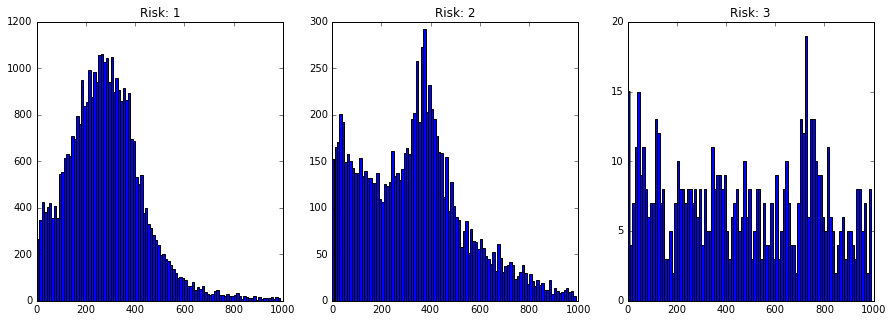

In [17]:
plt.figure(figsize=(15,5))
for i in range(1,4):
    plt.subplot(1,3,i)
    v = insp.ix[insp.Risk==i,'days_since_insp']
    plt.hist(v[v.notnull()].values,bins=np.arange(0,1000,10))
    plt.title('Risk: {}'.format(i))

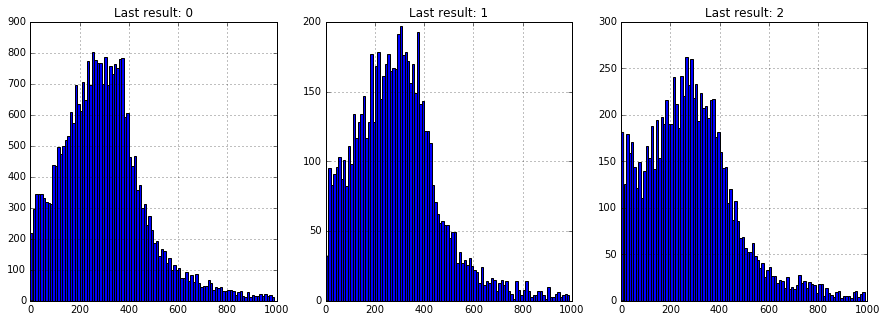

In [18]:
plt.figure(figsize=(15,5))
for i in range(1,4):
    plt.subplot(1,3,i)
    v = insp.ix[insp.last_insp_result==i-1,'days_since_insp']
    plt.hist(v[v.notnull()].values,bins=np.arange(0,1000,10))
    plt.title('Last result: {}'.format(i-1))
    plt.grid('on')

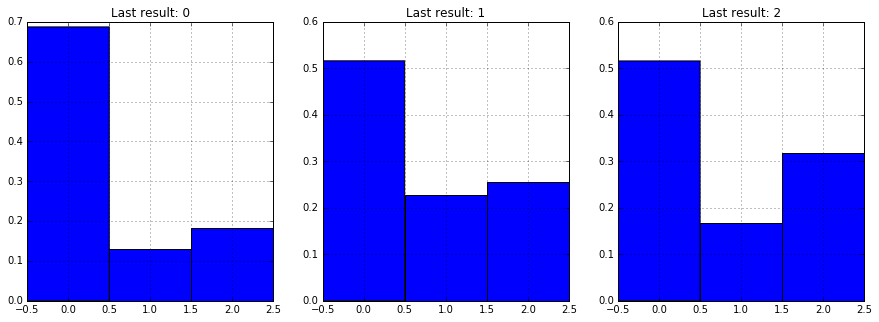

In [19]:
plt.figure(figsize=(15,5))
for i in range(1,4):
    plt.subplot(1,3,i)
    v = insp.ix[insp.last_insp_result==i-1,'Results']
    plt.hist(v[v.notnull()].values,bins=np.arange(0,4)-0.5,normed=True)
    plt.title('Last result: {}'.format(i-1))
    plt.grid('on')

In [20]:
insp.isnull().mean()

ID                  0.000000
license             0.000000
date                0.000000
Results             0.000000
Risk                0.000000
facility            0.000000
inspection_type     0.000000
month               0.000000
day                 0.000000
year                0.000000
day_of_week         0.000000
day_of_year         0.000000
Latitude            0.000000
Longitude           0.000000
Zip                 0.000243
x                   0.000000
y                   0.000000
days_since_insp     0.239863
last_insp_result    0.239863
mean_insp_result    0.239863
dtype: float64

(array([ 2296.,  2342.,  1733.,   927.,   776.,   675.,   480.,   500.,
          501.,   475.,   512.,   481.,   460.,   491.,   429.,   262.,
          372.,   431.,   414.,   249.]),
 array([ 733776. ,  733900.3,  734024.6,  734148.9,  734273.2,  734397.5,
         734521.8,  734646.1,  734770.4,  734894.7,  735019. ,  735143.3,
         735267.6,  735391.9,  735516.2,  735640.5,  735764.8,  735889.1,
         736013.4,  736137.7,  736262. ]),
 <a list of 20 Patch objects>)

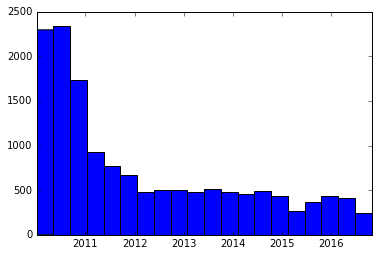

In [21]:
# This is justification to throw away the results from teh first year.  Start in 2011.
plt.hist(insp[insp.mean_insp_result.isnull()].date.values,bins=20)

In [22]:
# Fill in the missing values and make a missing predictor.
insp['first_insp']=1*insp['mean_insp_result'].isnull()
insp.ix[insp.mean_insp_result.isnull(),['mean_insp_result','days_since_insp','last_insp_result']]=-1


In [23]:
insp.isnull().mean()

ID                  0.000000
license             0.000000
date                0.000000
Results             0.000000
Risk                0.000000
facility            0.000000
inspection_type     0.000000
month               0.000000
day                 0.000000
year                0.000000
day_of_week         0.000000
day_of_year         0.000000
Latitude            0.000000
Longitude           0.000000
Zip                 0.000243
x                   0.000000
y                   0.000000
days_since_insp     0.000000
last_insp_result    0.000000
mean_insp_result    0.000000
first_insp          0.000000
dtype: float64

# Get predictors for 3-day high temp

In [24]:
weath = weath_big[['date','tmax','tavg']]

In [25]:
# Make 1-week rolling average column
# Fill in the missing daily highs (the last 2 days) with the existing daily averages.
weath.ix[2494:2495,'tmax'] = weath.ix[2494:2495,'tavg']
weath = weath.drop('tavg',axis=1)

weath.ix[:,'tavg_3day']=weath['tmax'].rolling(window=3,min_periods=1).mean()
weath.head(10)

,date,tmax,tavg_3day
0,2010-01-01,16.0,16.000000
1,2010-01-02,11.0,13.500000
2,2010-01-03,18.0,15.000000
3,2010-01-04,18.0,15.666667
4,2010-01-05,23.0,19.666667
5,2010-01-06,20.0,20.333333
6,2010-01-07,22.0,21.666667
7,2010-01-08,27.0,23.000000
8,2010-01-09,22.0,23.666667
9,2010-01-10,18.0,22.333333


In [26]:
weath.isnull().sum()

date         0
tmax         0
tavg_3day    0
dtype: int64

In [27]:
# add weather information to the inspection table
insp = pd.merge(insp,weath[['date','tmax','tavg_3day']],how='left',on='date').set_index(insp.index)

# Risk, Facility Types, and Inspection Types

In [28]:
it_dummies = pd.get_dummies(insp.inspection_type,prefix='it').drop('it_Canvass',axis=1)
ft_dummies = pd.get_dummies(insp.facility,prefix='ft').drop('ft_Restaurant',axis=1)
risk_dummies = pd.get_dummies(insp.Risk,prefix='risk').drop('risk_1.0',axis=1)


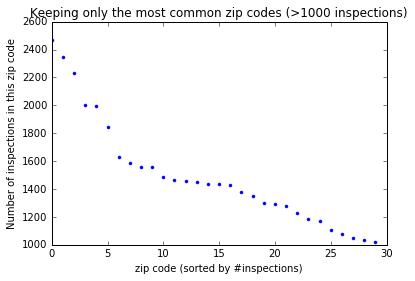

In [29]:
# I'm making a new filed, zip2, in which all the rare zips are replaced by nans.
insp.loc[:,'zip2'] = insp.Zip.copy()
smallzip_idx = insp.zip2.value_counts()<1000
smallzips = smallzip_idx.index[smallzip_idx]
insp.ix[insp.zip2.isin(smallzips),'zip2']=np.nan

v = insp.zip2.value_counts(normalize=False)
plt.plot(v.values,'.')
plt.ylabel('Number of inspections in this zip code')
plt.xlabel('zip code (sorted by #inspections)')
plt.title('Keeping only the most common zip codes (>1000 inspections)')

In [30]:
zip_dummies = pd.get_dummies(insp.zip2)

# KDE setup

In [31]:
train = insp.ix[:10000,['x','y','Results']]
test = insp.ix[10000:12000,['x','y','Results']]

In [32]:
def KDE_inspection_outcome(train,test):
    #localization parameter
    loc = 1.5e0 
    # get baseline rates
    br = train.Results.value_counts(normalize=True)
    
    # set up the models for the 
    # passed tests, provisional fails, and critical fails
    kde_pass = KDE(bandwidth=loc)
    kde_pfail = KDE(bandwidth=loc)
    kde_cfail = KDE(bandwidth=loc)
    
    # fit the models
    kde_pass.fit(train.ix[train['Results']==0,['x','y']].values)
    kde_pfail.fit(train.ix[train['Results']==1,['x','y']].values)
    kde_cfail.fit(train.ix[train['Results']==2,['x','y']].values)
    
    # get densities on the testing data
    Xtest = test[['x','y']].values
    k_pass  = np.exp( kde_pass.score_samples(Xtest))*br[0]
    k_pfail = np.exp(kde_pfail.score_samples(Xtest))*br[1]
    k_cfail = np.exp(kde_cfail.score_samples(Xtest))*br[2]
    
    # Get probabilities of pass, pfail, and cfail at all test points
    p_pass  = k_pass /(k_pass+k_pfail+k_cfail)
    p_pfail = k_pfail/(k_pass+k_pfail+k_cfail)
    p_cfail = k_cfail/(k_pass+k_pfail+k_cfail)
    
    return (np.concatenate((p_pass,p_pfail,p_cfail)).reshape(3,-1).T,
            np.concatenate((k_pass,k_pfail,k_cfail)).reshape(3,-1).T)
    #return pd.DataFrame({'p_pass':p_pass,'p_pfail':p_pfail,'p_cfail':p_cfail},index=test.index)


In [33]:
(df,_) = KDE_inspection_outcome(train,test)

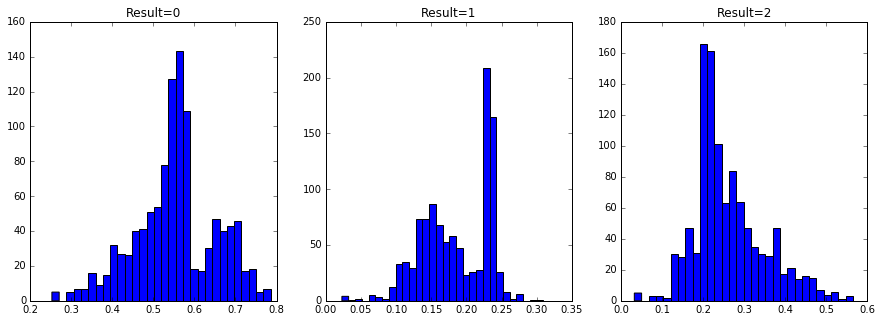

In [34]:
plt.figure(figsize=(15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.hist(df[:,i],bins=30)
    plt.title('Result={}'.format(i))

In [35]:
def plot_insp_KDE_pred(test,KDE_result,cmap=plt.get_cmap('RdYlGn_r'),title=None):
    plt.figure(figsize=(6,4))
    plt.scatter(test.x.values,test.y.values,c=KDE_result,cmap=cmap,s=60,vmin=0,vmax=1)
    if title:
        plt.title(title)
    plt.colorbar()


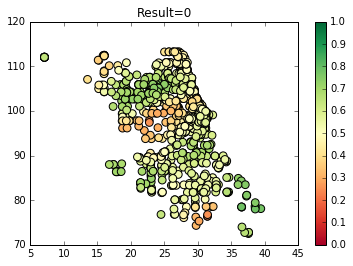

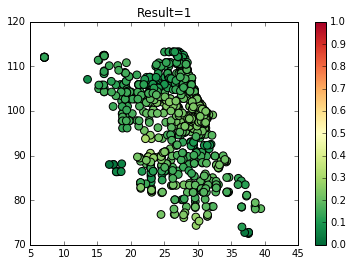

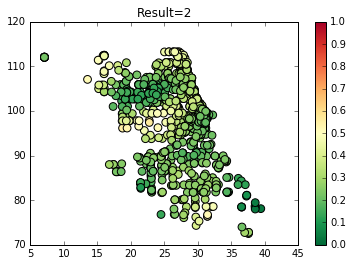

In [36]:
plot_insp_KDE_pred(test,df[:,0],plt.get_cmap('RdYlGn'),'Result=0')
plot_insp_KDE_pred(test,df[:,1],plt.get_cmap('RdYlGn_r'),'Result=1')
plot_insp_KDE_pred(test,df[:,2],plt.get_cmap('RdYlGn_r'),'Result=2')

In [37]:
xlocs = np.arange(5,45,1)
ylocs = np.arange(60,120,1)
xgrid,ygrid = np.meshgrid(xlocs,ylocs)
xylocs = pd.DataFrame(np.concatenate((xgrid.reshape(-1,1),ygrid.reshape(-1,1)),axis=1),columns=['x','y'])
(_,grid_predictions) = KDE_inspection_outcome(train,xylocs)

In [38]:
def plot_heatmap_probability(xgrid,ygrid,grid_pred,testlocs,idx_plotted=2,cmap=plt.get_cmap('RdYlGn_r'),title=None):
    p = grid_pred[:,idx_plotted]/grid_pred.sum(axis=1)
    plt.contourf(xgrid,ygrid,p.reshape(xgrid.shape),cmap=cmap,vmin=0,vmax=1)
    if title:
        plt.title(title)
    plt.colorbar()
    plt.grid('on')
    plt.scatter(testlocs.x,testlocs.y,color='k',s=5)

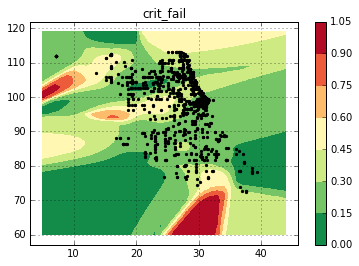

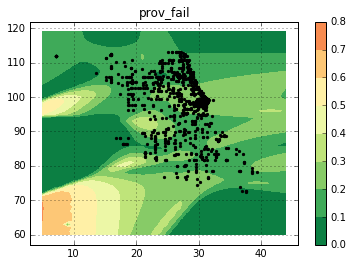

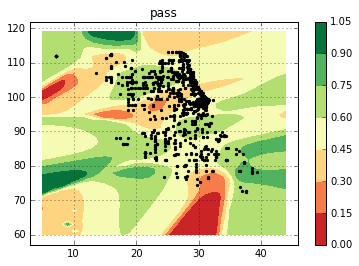

In [39]:
plot_heatmap_probability(xgrid,ygrid,grid_predictions,test,idx_plotted=2,title='crit_fail')
plt.show()
plot_heatmap_probability(xgrid,ygrid,grid_predictions,test,idx_plotted=1,title='prov_fail')
plt.show()
plot_heatmap_probability(xgrid,ygrid,grid_predictions,test,idx_plotted=0,title='pass',cmap=plt.get_cmap('RdYlGn'))

In [40]:
def plot_heatmap_density(xgrid,ygrid,grid_pred,testlocs,idx_plotted=2,cmap=plt.get_cmap('viridis'),title=None):
    p = grid_pred[:,idx_plotted]
    plt.contourf(xgrid,ygrid,p.reshape(xgrid.shape),cmap=cmap)
    if title:
        plt.title(title)
    plt.colorbar()
    plt.grid('on')
    plt.scatter(testlocs.x,testlocs.y,color='w',s=2)

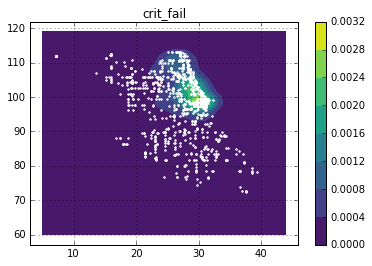

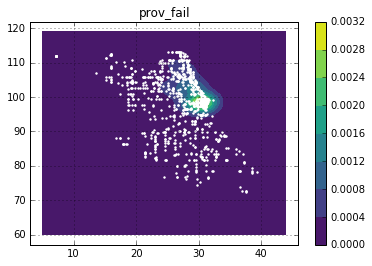

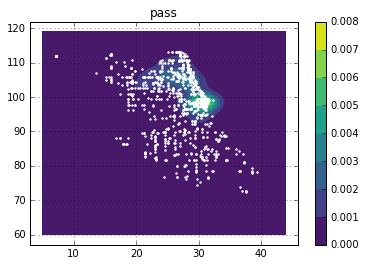

In [41]:
plot_heatmap_density(xgrid,ygrid,grid_predictions,test,idx_plotted=2,title='crit_fail')
plt.show()
plot_heatmap_density(xgrid,ygrid,grid_predictions,test,idx_plotted=1,title='prov_fail')
plt.show()
plot_heatmap_density(xgrid,ygrid,grid_predictions,test,idx_plotted=0,title='pass')

# Sanitation Complaints:


In [49]:
#%%time

# For each inspection, I will count the number of complaints within the last week and within a 0.5km radius.

# specify "close" in time and space
loc_dist = 0.5 #This is in km
loc_hist = pd.Timedelta(7, unit='d')

# pre-define the relevant sanitation and inspection data
insp_locs,insp_d = insp[['x','y']],insp['date']
san_x,san_y,san_d = comp['x'],comp['y'],comp['created']

# Loop through inspections; for each, find all the nearby recent sanitation complaints; count them.
ncomp_temp = np.empty((insp_locs.shape[0],2))
tstart = time.time()
for i,(rname,r) in enumerate(insp_locs.iterrows()):
    refx,refy = r
    idx = rname
    
    t = (san_d<=insp_d[idx]) & (san_d>(insp_d[idx]-loc_hist))
    d = (san_x[t]-refx)**2+(san_y[t]-refy)**2
    ncomp_temp[i,:] = [idx,(d<loc_dist).sum()]

    if (i+1)%10000==0:
        print i+1,time.time()-tstart
        
    

10000 84.4259998798
20000 165.440999985
30000 249.697000027
40000 335.715999842
50000 416.409999847
60000 497.672999859


In [58]:
# Turn the number of sanitation complaints into a dataframe.  
# Add it to insp.
ncomp = pd.Series(ncomp_temp[:,1],index=ncomp_temp[:,0],name='n_complaints')
insp = pd.concat((insp,ncomp),axis=1)

# Truncate the number of complaints at 10.  For all values over 10, replace them with 10.
# This is because these outcomes are extremely uncommon.
insp['n_comp_trunc']=insp['n_complaints']
insp.ix[insp.n_comp_trunc>10,'n_comp_trunc'] = 10

san = insp['n_comp_trunc']

0     5.0
4     1.0
5     1.0
7     0.0
11    0.0
13    1.0
16    2.0
18    0.0
19    1.0
26    0.0
28    0.0
32    1.0
33    3.0
35    1.0
37    0.0
39    1.0
47    7.0
49    1.0
54    6.0
55    0.0
Name: n_complaints, dtype: float64

In [59]:
insp['n_complaints'].head(5)

0     5.0
4     1.0
5     1.0
7     0.0
11    0.0
Name: n_complaints, dtype: float64

# Define the loss function

In [42]:
# For Ytrue (integers specifying class) and Ypred (n x m array of probabilities),
# calculate the negative log loss (i.e. neg log likelihood)

# Return the tuple (average neg log loss, characteristic probability)
def log_loss(Ytrue,Ypred):
    badidx = np.isnan(Ytrue)
    Ytrue = Ytrue[~badidx]
    Ypred = Ypred[~badidx,:]
    n,m = Ypred.shape
    
    if not np.issubdtype(Ytrue.dtype,np.integer):
        Ytrue = Ytrue.copy().astype('int')
    
    # p is the predicted probability of the event that happened
    p = Ypred[np.arange(n),Ytrue]
    # A hack to avoid being certain something will never happen
    # This sets the minimum value to 0.01
    x = 0.01031
    p = (p+x)/(1+3*x)
    
    ave_loss = -np.log(p).mean()
    char_p = np.exp(-ave_loss)
    return ave_loss,char_p

# Make some models!

In [43]:
# cut the first year since we don't know the previous results of those inspections.
insp_final = insp[insp.date>pd.datetime(2011,1,1)]
retidx = insp.date>pd.datetime(2011,1,1)
zip_dummies[retidx].shape

(53842, 30)

# Restaurant's history

In [44]:
insp_final.columns

Index([u'ID', u'license', u'date', u'Results', u'Risk', u'facility',
       u'inspection_type', u'month', u'day', u'year', u'day_of_week',
       u'day_of_year', u'Latitude', u'Longitude', u'Zip', u'x', u'y',
       u'days_since_insp', u'last_insp_result', u'mean_insp_result',
       u'first_insp', u'tmax', u'tavg_3day', u'zip2'],
      dtype='object')

In [45]:
Y = insp_final.Results.values

In [60]:
%%time

# Make logistic models adding factors to the dow-month-zip (time-place models)

# Do 10-fold CV to estimate generalization ability of the models.

n = Y.shape[0]
n_folds = 10
kf = TimeSeriesSplit(n_splits=n_folds)
#kf = KFold(n_splits=n_folds)

model_names = ['const','all_previous','add_t_since','add_results_previous','add_result_prev_&_mean','add_all']
n_models = len(model_names)

# Define the predictors for each model
X1 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx]),axis=1).values
X0 = (X1[:,0]*0+1).reshape(-1,1)
X2 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.days_since_insp),axis=1).values
X3 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2),axis=1).values
X4 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2,
                insp_final.mean_insp_result),axis=1).values
X5 = pd.concat((zip_dummies[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2,
                insp_final.mean_insp_result,insp_final.days_since_insp),axis=1).values

# Aggregate the predictors for all the models
allX = []
for i in range(n_models):
    allX.append(eval('X{}'.format(i)))

# Loop through the k-folds
mll = np.empty((n_folds,n_models))
charp = np.empty_like(mll)
for i,(ktrain,ktest) in enumerate(kf.split(Y)):
    
    for j in range(n_models):
        mdl = LogReg(C=1000).fit(allX[j][ktrain,:],Y[ktrain])
        Yproba = mdl.predict_proba(allX[j][ktest,:])
        mll[i,j],charp[i,j] = log_loss(Y[ktest],Yproba)

Wall time: 11 s


In [61]:
# Also fit the entire data to get in-sample fits
mll_insample = np.empty(n_models)
charp_insample = np.empty_like(mll_insample)
for j in range(n_models):
    mdl = LogReg(C=1000).fit(allX[j],Y)
    Yproba = mdl.predict_proba(allX[j])
    mll_insample[j],charp_insample[j] = log_loss(Y,Yproba)

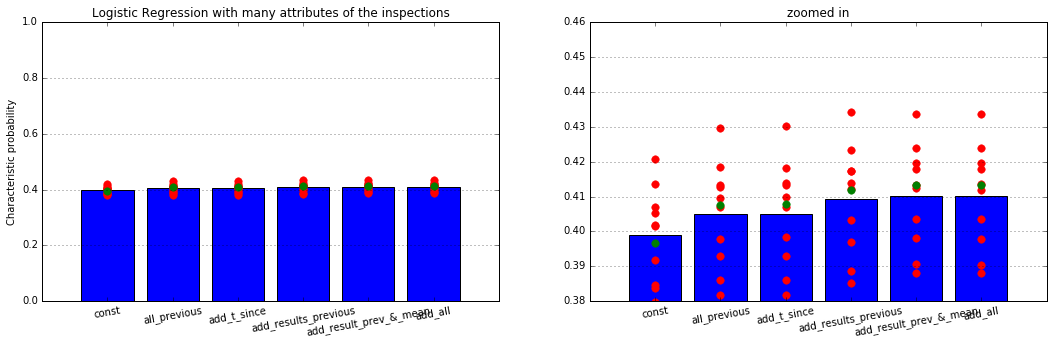

In [62]:
# Plot the characteristic probability for each of the models
plt.figure(figsize=(18,5))
for i in range(2):
    plt.subplot(1,2,i+1)
    mnp = charp.mean(axis=0)
    plt.bar(np.arange(n_models),mnp,align="center")
    mgx,_ = np.meshgrid(range(n_models),range(n_folds))
    plt.plot(mgx,charp,'r.',markersize=15)
    plt.plot(mgx[0,:],charp_insample,'g.',markersize=15)
    plt.xticks(mgx[0,:],model_names,rotation=10)
    plt.ylim([0,1])
    plt.grid(axis='y')
    plt.title('Logistic Regression with many attributes of the inspections')
    if i==1:
        plt.ylim([0.38,0.46])
        plt.title('zoomed in')
    else:
        plt.ylabel('Characteristic probability')
plt.show()

## Repeat above using sanitation instead of zip as location marker

In [69]:
%%time

# Make logistic models adding factors to the dow-month-zip (time-place models)

# Do 10-fold CV to estimate generalization ability of the models.

n = Y.shape[0]
n_folds = 10
kf = TimeSeriesSplit(n_splits=n_folds)
#kf = KFold(n_splits=n_folds)

model_names = ['const','all_previous','add_t_since','add_results_previous','add_result_prev_&_mean','add_all','add_all_z+s']
n_models = len(model_names)

# Define the predictors for each model
X1 = pd.concat((san[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx]),axis=1).values
X0 = (X1[:,0]*0+1).reshape(-1,1)
X2 = pd.concat((san[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.days_since_insp),axis=1).values
X3 = pd.concat((san[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2),axis=1).values
X4 = pd.concat((san[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2,
                insp_final.mean_insp_result),axis=1).values
X5 = pd.concat((san[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2,
                insp_final.mean_insp_result,insp_final.days_since_insp),axis=1).values
X6 = pd.concat((zip_dummies[retidx],san[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2,
                insp_final.mean_insp_result,insp_final.days_since_insp),axis=1).values

# Aggregate the predictors for all the models
allX = []
for i in range(n_models):
    allX.append(eval('X{}'.format(i)))

# Loop through the k-folds
mll = np.empty((n_folds,n_models))
charp = np.empty_like(mll)
for i,(ktrain,ktest) in enumerate(kf.split(Y)):
    
    for j in range(n_models):
        mdl = LogReg(C=1000).fit(allX[j][ktrain,:],Y[ktrain])
        Yproba = mdl.predict_proba(allX[j][ktest,:])
        mll[i,j],charp[i,j] = log_loss(Y[ktest],Yproba)

Wall time: 13.1 s


In [70]:
# Also fit the entire data to get in-sample fits
mll_insample = np.empty(n_models)
charp_insample = np.empty_like(mll_insample)
for j in range(n_models):
    mdl = LogReg(C=1000).fit(allX[j],Y)
    Yproba = mdl.predict_proba(allX[j])
    mll_insample[j],charp_insample[j] = log_loss(Y,Yproba)

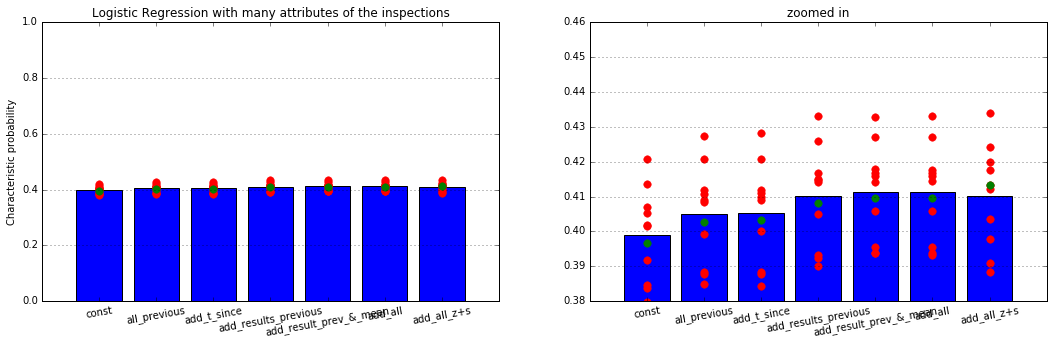

In [71]:
# Plot the characteristic probability for each of the models
plt.figure(figsize=(18,5))
for i in range(2):
    plt.subplot(1,2,i+1)
    mnp = charp.mean(axis=0)
    plt.bar(np.arange(n_models),mnp,align="center")
    mgx,_ = np.meshgrid(range(n_models),range(n_folds))
    plt.plot(mgx,charp,'r.',markersize=15)
    plt.plot(mgx[0,:],charp_insample,'g.',markersize=15)
    plt.xticks(mgx[0,:],model_names,rotation=10)
    plt.ylim([0,1])
    plt.grid(axis='y')
    plt.title('Logistic Regression with many attributes of the inspections')
    if i==1:
        plt.ylim([0.38,0.46])
        plt.title('zoomed in')
    else:
        plt.ylabel('Characteristic probability')
plt.show()

In [70]:
pd.DataFrame(mdl.coef_)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0.511964,0.237901,0.322942,-0.189060,0.109482,0.430299,-0.506565,-0.030564,0.142190,-0.517662,...,-0.808150,0.053680,-0.188322,0.076643,0.399504,-1.053541,-0.409363,-0.207522,-0.452321,-0.000158
1,-0.059022,0.070875,0.216043,0.219882,-0.182187,-0.265742,0.741955,0.260893,0.160859,0.620528,...,0.629934,-0.462059,0.087323,-0.037649,-1.226951,0.782782,0.456930,-0.008669,0.237638,0.000126
2,-0.794264,-0.471681,-0.747014,0.045628,-0.070275,-0.458377,-0.025050,-0.202495,-0.357949,0.081947,...,0.344542,0.226380,0.176083,-0.079516,0.170879,0.789101,0.176625,0.240957,0.414845,0.000043


## Putting it together: 
train until 2015, then in 2016, for each month, order by risk 2 type.  Then say how many would have been caught in the first half using (1) status quo; (2) baseline; (3) our model.  Average the months together.

In [72]:
# Train on data up to (including) 2015

# arrange training and testing data
X = pd.concat((san[retidx],it_dummies[retidx],ft_dummies[retidx],risk_dummies[retidx],
               insp_final.first_insp,insp_final.last_insp_result==1,insp_final.last_insp_result==2,
                insp_final.mean_insp_result,insp_final.days_since_insp),axis=1).values
X0 = (X[:,0]*0+1).reshape(-1,1)
ktrain = (insp_final.date<pd.datetime(2016,1,1)).values
ktest = []
ktest.append(None)
for i in range(1,11):
    temp = ((insp_final.date>=pd.datetime(2016,i,1)) & (insp_final.date<pd.datetime(2016,i+1,1))).values
    ktest.append(temp)

# train the model
mdl0 = LogReg(C=1000).fit(X0[ktrain,:],Y[ktrain])
mdl = LogReg(C=1000).fit(X[ktrain,:],Y[ktrain])

In [73]:
# For each month, order the inspections by risk according to all models.

comp_caught = np.empty((11,4))

for i in range(1,11):
    # Calculate model probabilities
    Yproba = mdl.predict_proba(X[ktest[i],:])
    df_test_month = pd.DataFrame(insp_final.iloc[ktest[i],:])
    df_test_month['mdl_score']=Yproba[:,2]
    
    # Sort the df by different quantities
    stat_quo = df_test_month.sort_values('date')
    bl_mdl = df_test_month.sample(frac=1)
    mdl_based = df_test_month.sort_values('mdl_score',ascending=False)

    # Check how many critical violations are caught in the first half
    n_half = len(df_test_month)//2
    comp_caught[i,0] = (stat_quo.iloc[:n_half,:].Results==2).sum()
    comp_caught[i,1] = (bl_mdl.iloc[:n_half,:].Results==2).sum()
    comp_caught[i,2] = (mdl_based.iloc[:n_half,:].Results==2).sum()
    comp_caught[i,3] = (df_test_month.Results==2).sum()
    

In [74]:
comp_caught[1:,:-1]

array([[ 100.,   88.,  109.],
       [ 110.,   90.,  121.],
       [ 117.,  130.,  155.],
       [ 101.,  112.,  147.],
       [  98.,  118.,  149.],
       [ 127.,  124.,  153.],
       [  90.,   84.,  110.],
       [ 127.,  109.,  141.],
       [  76.,   60.,   90.],
       [  26.,   26.,   36.]])

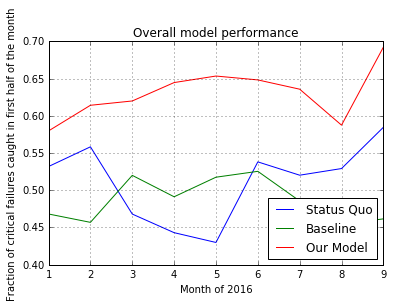

In [75]:
v = comp_caught[1:,:-1]/comp_caught[1:,-1].reshape(-1,1)

plt.plot(range(1,10),v[:-1,:])
plt.xlabel('Month of 2016')
plt.ylabel('Fraction of critical failures caught in first half of the month')
plt.legend(('Status Quo','Baseline','Our Model'),loc='lower right')
plt.grid('on')
plt.title('Overall model performance')

In [77]:
comp_caught[:,2].mean()/comp_caught[:,0].mean()

1.2458847736625516

### Zip vs KDE

In [78]:
Y = insp_final.Results.values

In [106]:
%%time
# First models: variants using the day of the week, month, and zip code. 
# These are analogous to baseline 1 above.

# Do 10-fold TSCV to estimate generalization ability of the models.

n = Y.shape[0]
n_folds = 10
kf = TimeSeriesSplit(n_splits=n_folds)

model_names = ['const','zip','KDE','sanitation']
n_models = len(model_names)

# Define the predictors for each model
X1 = zip_dummies[retidx].values
X0 = (X1[:,0]*0+1).reshape(-1,1)
X2 = insp_final[['x','y','Results']]
X3 = san[retidx].values.reshape(-1,1)

# Loop through the k-folds
mll = np.empty((n_folds,n_models))
charp = np.empty_like(mll)
for i,(ktrain,ktest) in enumerate(kf.split(X0)):
    mdl = LogReg(C=1000).fit(X0[ktrain,:],Y[ktrain])
    Yproba = mdl.predict_proba(X0[ktest,:])
    mll[i,0],charp[i,0] = log_loss(Y[ktest],Yproba)

    mdl = LogReg(C=1000).fit(X1[ktrain,:],Y[ktrain])
    Yproba = mdl.predict_proba(X1[ktest,:])
    mll[i,1],charp[i,1] = log_loss(Y[ktest],Yproba)
    
    Xtrain = X2.iloc[ktrain,:]
    Xtest = X2.iloc[ktest,:]
#     (df,_) = KDE_inspection_outcome(Xtrain,Xtrain)
#     mdl = LogReg(C=1000).fit(df[:,1:],Y[ktrain])
#     (df,_) = KDE_inspection_outcome(Xtrain,Xtest)
#     Yproba = mdl.predict_proba(df[:,1:])
    Yproba,_ = KDE_inspection_outcome(Xtrain,Xtest)
    mll[i,2],charp[i,2] = log_loss(Y[ktest],Yproba)
    
    mdl = LogReg(C=1000).fit(X3[ktrain,:],Y[ktrain])
    Yproba = mdl.predict_proba(X3[ktest,:])
    mll[i,3],charp[i,3] = log_loss(Y[ktest],Yproba)


Wall time: 1min 32s


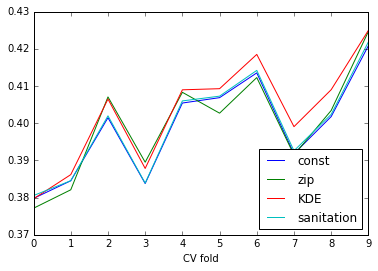

In [108]:
plt.plot(charp)
plt.legend(model_names,loc='lower right')
plt.xlabel('CV fold')

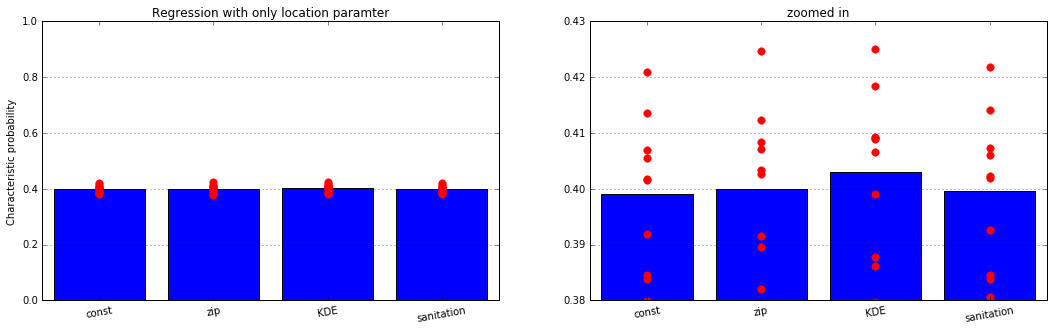

In [115]:
# Plot the characteristic probability for each of the models
plt.figure(figsize=(18,5))
for i in range(2):
    plt.subplot(1,2,i+1)
    mnp = charp.mean(axis=0)
    plt.bar(np.arange(n_models),mnp,align="center")
    mgx,_ = np.meshgrid(range(n_models),range(n_folds))
    plt.plot(mgx,charp,'r.',markersize=15)
    #plt.plot(mgx[0,:],charp_insample,'g.',markersize=15)
    plt.xticks(mgx[0,:],model_names,rotation=10)
    plt.ylim([0,1])
    plt.grid(axis='y')
    plt.title('Regression with only location paramter')
    if i==1:
        plt.ylim([0.38,0.43])
        plt.title('zoomed in')
    else:
        plt.ylabel('Characteristic probability')
plt.show()

KDE does do better at predicting outcomes than zip or no predictor.  i.e. it captured the spatial information better than zip alone.

In [88]:
charp.mean(axis=0)

array([ 0.39897922,  0.39986247,  0.40299571])

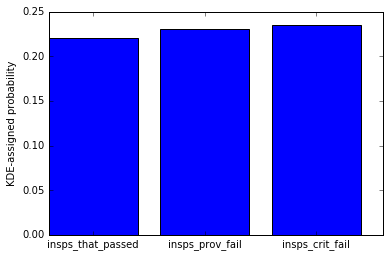

In [92]:
b = np.empty(3)
for i in range(3):
    b[i] =Yproba[Y[ktest]==i,2].mean()
plt.bar(range(3),b)
plt.xticks([0.4,1.4,2.4],['insps_that_passed','insps_prov_fail','insps_crit_fail'])
plt.ylabel('KDE-assigned probability')

# KDE for location

In [13]:
br = insp.Results.value_counts(normalize=True)

In [14]:
br[0],br[1],br[2]

(0.62222401940962391, 0.15522846744844318, 0.22254751314193288)

In [15]:
kde_pass = KDE(bandwidth=1e0)
X_df = insp.ix[insp['x'].notnull(),['x','y','Results']]
X = X_df.ix[X_df['Results']==0,['x','y']].values

kde_pass.fit(X)

xlocs = np.arange(5,45,1)
ylocs = np.arange(60,120,1)
xgrid,ygrid = np.meshgrid(xlocs,ylocs)



In [16]:
X.shape

(38409L, 2L)

In [136]:
%%time
den_pass = kde_pass.score_samples(np.concatenate((xgrid.reshape(-1,1),ygrid.reshape(-1,1)),axis=1))
den_pass = np.exp(den_pass.reshape(xgrid.shape))*br[0]

Wall time: 3.32 s


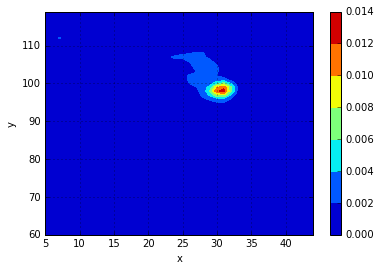

In [137]:
#plt.pcolormesh(xgrid,ygrid,densities,vmin=-1.e2,vmax=0.)
plt.contourf(xgrid,ygrid,den_pass)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
#plt.scatter(X[[0,4],0],X[[0,4],1],color='r')
plt.grid('on')

In [138]:
kde_cf = KDE(bandwidth=1e0)
X = X_df.ix[X_df['Results']==2,['x','y']].values

kde_cf.fit(X)

xlocs = np.arange(5,45,1)
ylocs = np.arange(60,120,1)
xgrid,ygrid = np.meshgrid(xlocs,ylocs)



In [139]:
X.shape

(13744L, 2L)

In [140]:
%%time
den_cf = kde_cf.score_samples(np.concatenate((xgrid.reshape(-1,1),ygrid.reshape(-1,1)),axis=1))
den_cf = np.exp(den_cf.reshape(xgrid.shape))*br[2]

Wall time: 1.26 s


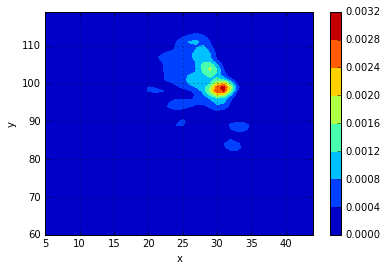

In [162]:
#plt.pcolormesh(xgrid,ygrid,densities,vmin=-1.e2,vmax=0.)
plt.contourf(xgrid,ygrid,den_cf)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
#plt.scatter(X[[0,4],0],X[[0,4],1],color='r')
plt.grid('on')

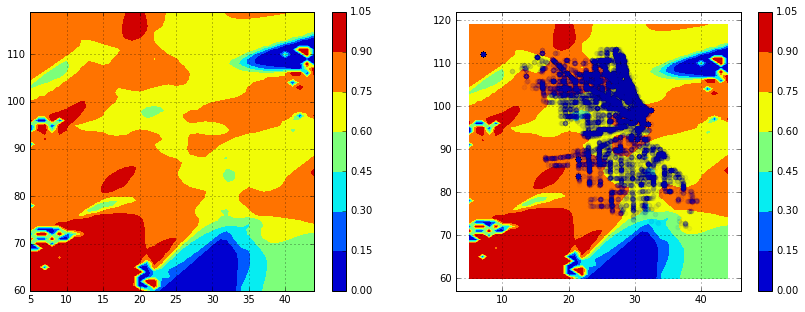

In [167]:
plt.figure(figsize=(14,5))
for i in range(1,3):
    plt.subplot(1,2,i)
    plt.contourf(xgrid,ygrid,den_pass/(den_pass+den_cf))
    plt.colorbar()
    plt.grid('on')
plt.scatter(X_df.x,X_df.y,color='b',alpha=0.01)

In [143]:
den_pass.max(),den_pass.min(),den_cf.max(),den_cf.min()

(0.012588324054318487,
 3.0428885186486529e-139,
 0.003000125118141495,
 3.9183230981077174e-142)

In [152]:
%%time
k_pass = np.exp(kde_pass.score_samples(X_df[['x','y']].values))*br[0]
k_cf = np.exp(kde_cf.score_samples(X_df[['x','y']].values))*br[2]

Wall time: 2min 55s


In [147]:
p_pass = k_pass/(k_pass+k_cf)
p_pass.min(),p_pass.max()

(0.22902947157149359, 0.90399234442299026)

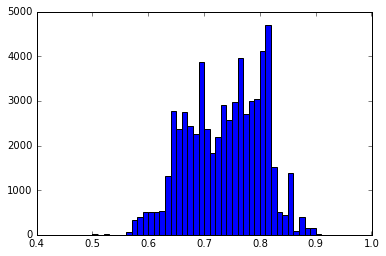

In [151]:
plt.hist(p_pass,bins=np.arange(0.5,1.0,0.01))
plt.show()

### KDE for sanitation

In [113]:
kde = KDE(bandwidth=5e-1)
X = comp.ix[comp['x'].notnull(),['x','y']].values
#kde.fit(X[[0,4],:])
kde.fit(X)

KernelDensity(algorithm='auto', atol=0, bandwidth=0.5, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

In [114]:
xlocs = np.arange(5,45,0.1)
ylocs = np.arange(60,120,0.1)
xgrid,ygrid = np.meshgrid(xlocs,ylocs)

In [115]:
xgrid.shape
300*200
insp.shape

(61825, 16)

In [ ]:
%%time
#densities = kde.score_samples(np.concatenate((xgrid.reshape(-1,1),ygrid.reshape(-1,1)),axis=1))

In [ ]:
densities = np.exp(densities.reshape(xgrid.shape))

In [ ]:
#plt.pcolormesh(xgrid,ygrid,densities,vmin=-1.e2,vmax=0.)
plt.contourf(xgrid,ygrid,densities)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
#plt.scatter(X[[0,4],0],X[[0,4],1],color='r')
plt.grid('on')

In [ ]:
plt.scatter(comp.x,comp.y,alpha=0.005)
plt.xlim([5,45])
plt.ylim([60,120])

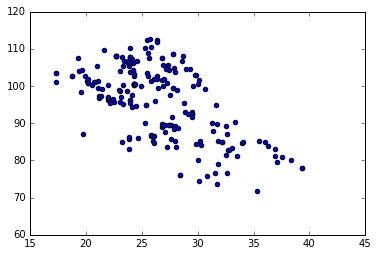

In [90]:
plt.scatter(X[0:200,0],X[:200,1])

KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

(0, 5)

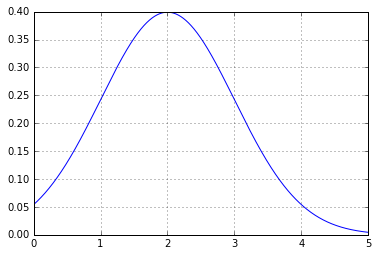

In [118]:
X = np.array([2,])
k = KDE(bandwidth=1e0)
k.fit(X.reshape(-1,1))

x = np.arange(-10,20,0.001)
y = np.exp(k.score_samples(x.reshape(-1,1)))
plt.plot(x,y)
plt.grid('on')
plt.xlim([0,5])
#plt.ylim([-20,0])

In [22]:
np.exp(1)

2.7182818284590451